
# Movies Classification Project

 <img src="http://usblogs.pwc.com/emerging-technology/wp-content/uploads/2017/07/deep-learning-900x280.png" >


# Deep Learning - Color Images


Developed by [Sergio Castelblanco](http://www.linkedin.com/in/sergio-castelblanco/) - [Jesus Solano](mailto:ja.solano588@uniandes.edu.co)

Andes University

version 2.1, July 9 2018

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import livelossplot
%matplotlib inline

Using TensorFlow backend.


# Read Data

In [0]:
# If datasets already exist do nothing. 

if not os.path.exists('dataTesting.csv'):
  ! wget https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/datasets/dataTesting.csv
    
if not os.path.exists('dataTraining.csv'):
  ! wget https://raw.githubusercontent.com/castellwhite/MoviesClassification/master/datasets/dataTraining.csv
    

if not os.path.exists('images_resize_color.zip'):
  # Install the PyDrive wrapper & import libraries.
  # This only needs to be done once per notebook.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # Authenticate and create the PyDrive client.
  # This only needs to be done once per notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Download a file based on its file ID(Grey).
  #
  # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
  file_id = '1ZO1wPtxWfnthbm2NrXt4ca1ZvuxQWD_r'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(downloaded['title'])
  !unzip -q images_resize_color.zip 

dataTraining = pd.read_csv("dataTraining.csv",index_col=0)
dataTesting = pd.read_csv("dataTesting.csv",index_col=0)

In [3]:
! ls

datalab		  images_resize_color	   images_resize_gray.zip
dataTesting.csv   images_resize_color.zip  imaNNtrainedGray.h5
dataTraining.csv  images_resize_gray	   imaNNtrainedGrayVGG.h5


In [4]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Read Images

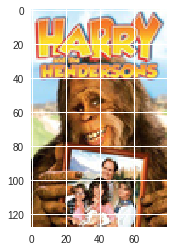

In [8]:
# Show an image example - Gray 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
from skimage.transform import resize

targetX=80
targetY=128

image= load_img(os.path.join( 'images_resize_color/', str(dataTraining.index[124]) + '.jpeg'))
image = image.resize((targetX,targetY),Image.ANTIALIAS)

#print(image.shape)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image)

In [9]:
# Load all gray images.


from skimage.transform import resize
from PIL import Image

targetX=40
targetY=64

print('\nLoading images for traning...')
images_training = []
for i in dataTraining.index:
    tempImage = load_img(os.path.join( 'images_resize_color/', str(i) + '.jpeg'))
    tempImage = tempImage.resize((targetX,targetY),Image.ANTIALIAS)
    images_training.append(img_to_array(tempImage))
    
    
trainingImagesColor = np.asarray(images_training)




Loading images for traning...


In [10]:
trainingImagesColor.shape

(7895, 64, 40, 3)

In [11]:
'''
print('\nLoading images for testing...')
images_testing = []
for i in dataTesting.index:
    tempImage = load_img(os.path.join( 'images_resize_color/', str(i) + '.jpeg'))
    tempImage = tempImage.resize((targetX,targetY),Image.ANTIALIAS)
    images_training.append(img_to_array(tempImage))

testingImagesColor = np.asarray(images_testing)

'''

"\nprint('\nLoading images for testing...')\nimages_testing = []\nfor i in dataTesting.index:\n    tempImage = load_img(os.path.join( 'images_resize_color/', str(i) + '.jpeg'))\n    tempImage = tempImage.resize((targetX,targetY),Image.ANTIALIAS)\n    images_training.append(img_to_array(tempImage))\n\ntestingImagesColor = np.asarray(images_testing)\n\n"

In [0]:
from keras.applications import VGG16
from skimage.transform import resize

vgg16 = VGG16(include_top=False, weights='imagenet')

trainingImagesVGG = vgg16.predict(trainingImagesColor)
  

In [0]:
# Get labels for each image. 

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
yGenres = le.fit_transform(dataTraining['genres'])

# Convolutional Neural Network --- VGG16 Model



In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense ,BatchNormalization
from keras import backend as K
from keras import optimizers as opts
from keras.callbacks import History
from livelossplot import PlotLossesKeras


In [0]:
########## Transfer learnring ##########


# Creates datasets for training and testing.   
xTrainImaColorVGG, xValidationImaColorVGG, yTrainImaColorVGG, yValidationImaColorVGG = train_test_split(trainingImagesVGG, yGenres, test_size=0.20, random_state=22)

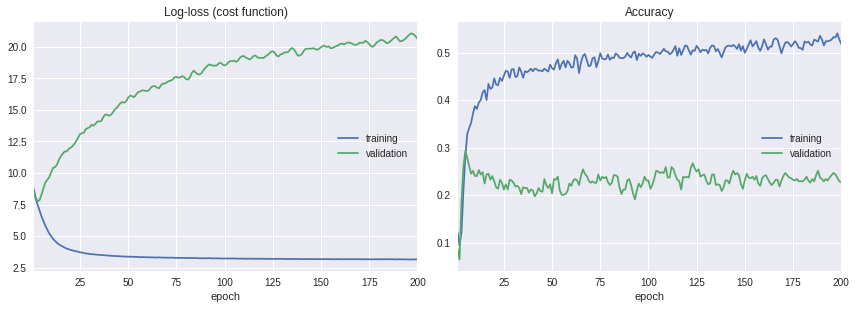

In [19]:
### Transfer Learning Neural Network.

from google.colab import files
from keras import backend as K
K.clear_session()

# Model structure.
outputClasses = 24

# Create the model. 
cnnTransferColor = Sequential()

# Apply a convolutional layer. 
cnnTransferColor.add(Flatten(input_shape=xTrainImaColorVGG.shape[1:]))

# Add the fully connected.
cnnTransferColor.add(Dense(512, activation='relu',init='uniform'))
cnnTransferColor.add(BatchNormalization())

# Add a dropout.
cnnTransferColor.add(Dropout(0.3))

# Add the fully connected.
cnnTransferColor.add(Dense(outputClasses,init='uniform'))
#cnnTransferColor.add(BatchNormalization())

# Add the activation softmax.
cnnTransferColor.add(Activation('sigmoid'))

print(cnnTransferColor.summary(70))

# Compile the model. 

op = opts.Adam(lr=0.01)

cnnTransferColor.compile(loss = 'categorical_crossentropy',
              optimizer = op,
              metrics = ['accuracy'])

batch_size = 2000
epochs = 200

cnnTransferColor.fit(xTrainImaColorVGG, yTrainImaColorVGG,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle = True, 
                    validation_split = 0.1,
                    callbacks=[PlotLossesKeras()])

cnnTransferColor.save('imaNNtrainedColorVGG.h5')

files.download('imaNNtrainedColorVGG.h5')

In [20]:
# Scoring model for grey images.

from sklearn.metrics import roc_curve, auc, roc_auc_score

yPredGenreIma = cnnTransferColor.predict(xValidationImaColorVGG)
imaAUC = roc_auc_score(yValidationImaColorVGG, yPredGenreIma, average='macro')

# Perform the neural network over the test set. 

print('Evaluating the test set...')
score = cnnTransferColor.evaluate(xValidationImaColorVGG, yValidationImaColorVGG)

print('\nTest score:', score[0])
print('Test accuracy:', score[1])
print('Model AUC is: ', imaAUC )


Evaluating the test set...
1579/1579 [==============================] - 0s 74us/step

Test score: 20.450474746926364
Test accuracy: 0.22419252699126618
Model AUC is:  0.6102209258197484


In [0]:
files.download('imaNNtrainedColorVGG.h5')

## Print Prediction to Kaggle

In [0]:
# Print prediction for test (kaggle) data. 

from keras.models import load_model
from google.colab import files

cnnTransferColor = load_model('imaNNtrainedColorVGG.h5')

yPredTest = nnIma.predict(testingImagesColor)

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

pd.DataFrame(yPredTest, index=dataTesting.index, columns=cols).to_csv('pred_genres_ImageVGG_Color.csv', index_label='ID')

files.download('pred_genres_ImageVGG_Color.csv')


# Own CNN Network - Color

In [0]:
# Creates datasets for training and testing.   
xTrainImaColor, xValidationImaColor, yTrainImaColor, yValidationImaColor = train_test_split(trainingImagesColor, yGenres, test_size=0.20, random_state=22)

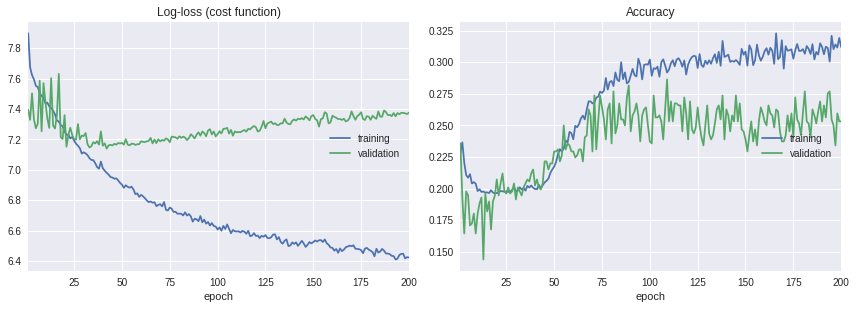

In [34]:
# Neural Network used to train Color images -- Own model.

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers as opts
from keras.callbacks import History
from livelossplot import PlotLossesKeras

from keras import backend as K
K.clear_session()

outputClasses = 24

xSize = xTrainImaColor.shape[1]
ySize = xTrainImaColor.shape[2]

# Define if images have color channels firts in the array.
if K.image_data_format() == 'channels_first':
    input_shape = (3, xSize, ySize)
else:
    input_shape = (xSize, ySize, 3)


# Creates a CNN model using keras.

nnIma = Sequential()

filtersNumber1=32
filtersNumber2=64

kernelSize= 32
maxPoolSize = 2 

NumN=32
NumN2=64

nnIma.add(Conv2D(NumN, (3, 3), input_shape=input_shape))
nnIma.add(Activation('tanh'))
nnIma.add(MaxPooling2D(pool_size=(2, 2)))
nnIma.add(Dropout(0.3))

nnIma.add(Conv2D(NumN, (3, 3)))
nnIma.add(Activation('tanh'))
nnIma.add(MaxPooling2D(pool_size=(2, 2)))
nnIma.add(Dropout(0.3))

nnIma.add(Conv2D(NumN2, (3, 3)))
nnIma.add(Activation('tanh'))
nnIma.add(MaxPooling2D(pool_size=(2, 2)))
nnIma.add(Dropout(0.3))

nnIma.add(Flatten())
nnIma.add(Dense(NumN2))
nnIma.add(Activation('tanh'))
nnIma.add(Dropout(0.3))
nnIma.add(Dense(outputClasses))
nnIma.add(Activation('sigmoid'))

nnIma.summary()

#Defines optimizer.
op = opts.Adam(lr=0.001)

# Compile the neural network.
nnIma.compile(loss='categorical_crossentropy',
             optimizer=op,
              metrics=['accuracy'])

batch_size = 150
epochs = 200

nnIma.fit(xTrainImaColor, yTrainImaColor,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle = True, 
                    #validation_data = [xValidationImaColor,yValidationImaColor],
                    validation_split = 0.1,
                    callbacks=[PlotLossesKeras()])


nnIma.save('imaNNtrainedColor.h5')
files.download('imaNNtrainedColor.h5')

In [35]:
# Scoring model for grey images.

from sklearn.metrics import roc_curve, auc, roc_auc_score

yPredGenreIma = nnIma.predict(xValidationImaColor)
imaAUC = roc_auc_score(yValidationImaColor, yPredGenreIma, average='macro')

# Perform the neural network over the test set. 

print('Evaluating the test set...')
score = nnIma.evaluate(xValidationImaColor, yValidationImaColor)

print('\nTest score:', score[0])
print('Test accuracy:', score[1])
print('Model AUC is: ', imaAUC )

Evaluating the test set...
1579/1579 [==============================] - 0s 146us/step

Test score: 7.371359749033604
Test accuracy: 0.2571247625834131
Model AUC is:  0.6285311430754646


In [0]:
files.download('imaNNtrainedColor.h5')

## Print Prediction to Kaggle

In [0]:
# Print prediction for test (kaggle) data. 

from keras.models import load_model
from google.colab import files

cnnTransferColor = load_model('imaNNtrainedColor.h5')

yPredTest = nnIma.predict(testingImagesColor)

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

pd.DataFrame(yPredTest, index=dataTesting.index, columns=cols).to_csv('pred_genres_ImageVGG_Color.csv', index_label='ID')

files.download('pred_genres_ImageVGG_Color.csv')


In [0]:
https://arxiv.org/pdf/1702.01992.pdf

In [0]:
!pip3 install tqdm
!pip3 install livelossplot

In [0]:
! rm -r *